# modelling agential learning in the two-agent agency task using active inference

non-exhaustive list of variables you can play around with on this script:
* expcondition: this manipulates the experimental condition. You may specify it to be a certain condition from the following list: ['s_pos_o_pos', 's_pos_o_neg', 's_pos_o_zer', 's_neg_o_pos', 's_neg_o_neg', 's_neg_o_zer', 's_zer_o_pos', 's_zer_o_neg', 's_zer_o_zer']. You may also set it to None and let the script randomly select an experimental condition from the list.

* p_outcome_env: this manipulates how volatile the environment (generative process) is. 1.0 is a fully deterministic environment - i.e., in the experimental condition of positive agency, every time the agent presses the button, the light turns on 100% of the time. If set to 0.8, then the environment is probabilistic or volatile - i.e., every time the agent presses the button, the light turn on 80% of the time.

* p_outcome: this manipulates how volatile the agent believes the environment is, and it is reflected in its generative model's A tensor. The agent may then learn how volatile the environment actually is by updating its A tensor at every timestep.
* outcomepref: this sets the preference for the outcome. Set it as high or low as you wish.

* actionpref: this sets the preference for producing an action (i.e., pressing the button).

* noactionpref: this sets the preference for not producing an action (i.e., not pressing the button), and can be interpreted as having a cost towards producing an action.

* lr_pA: this is the learning rate parameter for learning/updating of the A tensor. 


#### prerequisites (loading packages)

In [49]:
# !pip install inferactively-pymdp # the sparse-likelilihoods_111 branch was used here
import os
import sys
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import pymdp
from pymdp import utils 
from pymdp import maths
from pymdp.agent import Agent

### THE GENERATIVE MODEL

#### specifying the states and observations

In [50]:
""" Defining state factors """
self_agency_names = ['self_positivecontrol', 'self_negativecontrol', 'self_zerocontrol']
other_agency_names = ['other_positivecontrol', 'other_negativecontrol', 'other_zerocontrol']
self_action_names = ['self_buttonpress', 'self_buttonnotpress']
other_action_names = ['other_buttonpress', 'other_buttonnotpress']

""" Defining number of state factors and states """
num_states = [len(self_agency_names), len(other_agency_names), len(self_action_names), len(other_action_names)]
num_factors = len(num_states)

""" Defining control state factors """
choice_self_agency_names = ['no_changes']
choice_other_agency_names = ['no_changes']
choice_self_action_names = ['self_pressbutton', 'self_notpressbutton']
choice_other_action_names = ['equal_distribution']

""" Defining number of control states """
num_controls = [len(choice_self_agency_names), len(choice_other_agency_names), 
                len(choice_self_action_names), len(choice_other_action_names)]

""" Defining observational modalities """
obs_outcome_names = ['outcome_present', 'outcome_absent']
obs_choice_self_names = ['self_buttonpress', 'self_buttonnotpress']
obs_choice_other_names = ['other_buttonpress', 'other_buttonnotpress']

""" Defining number of observational modalities and observations """
num_obs = [len(obs_outcome_names), len(obs_choice_self_names), len(obs_choice_other_names)]
num_modalities = len(num_obs)

#### likelihood (A) tensors

In [51]:
def create_A(p_outcome):
    
    A_gp = utils.obj_array(num_modalities)
    
    ''' A matrix for outcome '''
    
    A_outcome = np.zeros( (len(obs_outcome_names), len(self_agency_names), 
                           len(other_agency_names), len(self_action_names), len(other_action_names)) )
    
    # SELF_POS, OTHER_POS
    
    # p(outcome | self_pos, other_pos, self_press, other_press)
    #                       present    absent
    A_outcome[:,0,0,0,0] = [p_outcome, 1.0-p_outcome]
    
    # p(outcome | self_pos, other_pos, self_notpress, other_press)
    #                       present    absent
    A_outcome[:,0,0,1,0] = [1.0-p_outcome, p_outcome]
    
    # p(outcome | self_pos, other_pos, self_press, other_notpress)
    #                       present    absent
    A_outcome[:,0,0,0,1] = [1.0-p_outcome, p_outcome]
    
    # p(outcome | self_pos, other_pos, self_notpress, other_notpress)
    #                       present    absent
    A_outcome[:,0,0,1,1] = [1.0-p_outcome, p_outcome]
    
    # SELF_POS, OTHER_NEG
    
    # p(outcome | self_pos, other_neg, self_press, other_press)
    #                       present    absent
    A_outcome[:,0,1,0,0] = [1.0-p_outcome, p_outcome]
    
    # p(outcome | self_pos, other_neg, self_notpress, other_press)
    #                       present    absent
    A_outcome[:,0,1,1,0] = [1.0-p_outcome, p_outcome]
    
    # p(outcome | self_pos, other_neg, self_press, other_notpress)
    #                       present    absent
    A_outcome[:,0,1,0,1] = [p_outcome, 1.0-p_outcome]
    
    # p(outcome | self_pos, other_neg, self_notpress, other_notpress)
    #                       present    absent
    A_outcome[:,0,1,1,1] = [1.0-p_outcome, p_outcome]
    
    # SELF_POS, OTHER_ZERO
    
    # p(outcome | self_pos, other_zero, self_press, other_press)
    #                       present    absent
    A_outcome[:,0,2,0,0] = [p_outcome, 1.0-p_outcome]
    
    # p(outcome | self_pos, other_zero, self_notpress, other_press)
    #                       present    absent
    A_outcome[:,0,2,1,0] = [1.0-p_outcome, p_outcome]
    
    # p(outcome | self_pos, other_zero, self_press, other_notpress)
    #                       present    absent
    A_outcome[:,0,2,0,1] = [p_outcome, 1.0-p_outcome]
    
    # p(outcome | self_pos, other_zero, self_notpress, other_notpress)
    #                       present    absent
    A_outcome[:,0,2,1,1] = [1.0-p_outcome, p_outcome]
    
    # SELF_NEG, OTHER_POS
    
    # p(outcome | self_neg, other_pos, self_press, other_press)
    #                       present    absent
    A_outcome[:,1,0,0,0] = [1.0-p_outcome, p_outcome]
    
    # p(outcome | self_neg, other_pos, self_notpress, other_press)
    #                       present    absent
    A_outcome[:,1,0,1,0] = [p_outcome, 1.0-p_outcome]
    
    # p(outcome | self_neg, other_pos, self_press, other_notpress)
    #                       present    absent
    A_outcome[:,1,0,0,1] = [1.0-p_outcome, p_outcome]
    
    # p(outcome | self_neg, other_pos, self_notpress, other_notpress)
    #                       present    absent
    A_outcome[:,1,0,1,1] = [1.0-p_outcome, p_outcome]
    
    # SELF_NEG, OTHER_NEG
    
    # p(outcome | self_neg, other_neg, self_press, other_press)
    #                       present    absent
    A_outcome[:,1,1,0,0] = [1.0-p_outcome, p_outcome]
    
    # p(outcome | self_neg, other_neg, self_notpress, other_press)
    #                       present    absent
    A_outcome[:,1,1,1,0] = [1.0-p_outcome, p_outcome]
    
    # p(outcome | self_neg, other_neg, self_press, other_notpress)
    #                       present    absent
    A_outcome[:,1,1,0,1] = [1.0-p_outcome, p_outcome]
    
    # p(outcome | self_neg, other_neg, self_notpress, other_notpress)
    #                       present    absent
    A_outcome[:,1,1,1,1] = [p_outcome, 1.0-p_outcome]
        
    
    # SELF_NEG, OTHER_ZERO
    
    # p(outcome | self_neg, other_zero, self_press, other_press)
    #                       present    absent
    A_outcome[:,1,2,0,0] = [1.0-p_outcome, p_outcome]
    
    # p(outcome | self_neg, other_zero, self_notpress, other_press)
    #                       present    absent
    A_outcome[:,1,2,1,0] = [p_outcome, 1.0-p_outcome]
    
    # p(outcome | self_neg, other_zero, self_press, other_notpress)
    #                       present    absent
    A_outcome[:,1,2,0,1] = [1.0-p_outcome, p_outcome]
    
    # p(outcome | self_neg, other_zero, self_notpress, other_notpress)
    #                       present    absent
    A_outcome[:,1,2,1,1] = [p_outcome, 1.0-p_outcome]
    
    
    # SELF_ZERO, OTHER_POS
    
    # p(outcome | self_zero, other_pos, self_press, other_press)
    #                       present    absent
    A_outcome[:,2,0,0,0] = [p_outcome, 1.0-p_outcome]
    
    # p(outcome | self_zero, other_pos, self_notpress, other_press)
    #                       present    absent
    A_outcome[:,2,0,1,0] = [p_outcome, 1.0-p_outcome]
    
    # p(outcome | self_zero, other_pos, self_press, other_notpress)
    #                       present    absent
    A_outcome[:,2,0,0,1] = [1.0-p_outcome, p_outcome]
    
    # p(outcome | self_zero, other_pos, self_notpress, other_notpress)
    #                       present    absent
    A_outcome[:,2,0,1,1] = [1.0-p_outcome, p_outcome]
    
    # SELF_ZERO, OTHER_NEG
    
    # p(outcome | self_zero, other_neg, self_press, other_press)
    #                       present    absent
    A_outcome[:,2,1,0,0] = [1.0-p_outcome, p_outcome]
    
    # p(outcome | self_zero, other_neg, self_notpress, other_press)
    #                       present    absent
    A_outcome[:,2,1,1,0] = [1.0-p_outcome, p_outcome]
    
    # p(outcome | self_zero, other_neg, self_press, other_notpress)
    #                       present    absent
    A_outcome[:,2,1,0,1] = [p_outcome, 1.0-p_outcome]
    
    # p(outcome | self_zero, other_neg, self_notpress, other_notpress)
    #                       present    absent
    A_outcome[:,2,1,1,1] = [p_outcome, 1.0-p_outcome]
    
    # SELF_ZERO, OTHER_ZERO
    
    # p(outcome | self_zero, other_zero, self_press, other_press)
    #                       present    absent
    A_outcome[:,2,2,0,0] = [0.5, 0.5]
    
    # p(outcome | self_zero, other_zero, self_notpress, other_press)
    #                       present    absent
    A_outcome[:,2,2,1,0] = [0.5, 0.5]
    
    # p(outcome | self_zero, other_zero, self_press, other_notpress)
    #                       present    absent
    A_outcome[:,2,2,0,1] = [0.5, 0.5]
    
    # p(outcome | self_zero, other_zero, self_notpress, other_notpress)
    #                       present    absent
    A_outcome[:,2,2,1,1] = [0.5, 0.5]

    ''' A matrix for proprioception '''
    A_choice_self = np.zeros((len(obs_choice_self_names), len(self_action_names)))
    
    A_choice_self = np.eye(len(self_action_names))
    
    ''' A matrix for observing other agent's actions '''
    A_choice_other = np.zeros((len(obs_choice_other_names), len(other_action_names)))
    
    A_choice_other = np.eye(len(other_action_names))
    
    ''' stacking up the A matrices '''
    A_gp[0], A_gp[1], A_gp[2] = A_outcome, A_choice_self, A_choice_other
    A_factor_list = [[0,1,2,3], [2], [3]]
    
    A_gp = utils.norm_dist_obj_arr(A_gp)
    
    pA = utils.dirichlet_like(A_gp, scale = 1.0)

    pA[0] = pA[0] / np.sum(pA[0])

    A = utils.norm_dist_obj_arr(pA) 
    
    return A, A_factor_list, pA

controllable_indices = [2]
learnable_modalities = [0]

#### state transition (B) tensors

In [52]:
def create_B():
    
    B = utils.initialize_empty_B(num_states, num_states)
    
    ''' B matrix for context regarding the self '''
    B_self_context = np.zeros( (len(self_agency_names), len(self_agency_names), len(choice_self_agency_names)) )
    B_self_context[:,:,0] = np.eye(len(self_agency_names))
        
    ''' B matrix for context regarding the other '''
    B_other_context = np.zeros( (len(other_agency_names), len(other_agency_names), len(choice_other_agency_names)) )
    B_other_context[:,:,0] = np.eye(len(other_agency_names))
    
    ''' B matrix for actions the self can make '''
    B_self_choice = np.zeros( (len(self_action_names), len(self_action_names), len(choice_self_action_names)) )
    
    for choice_id in range(len(self_action_names)):
        B_self_choice[choice_id, :, choice_id] = 1.0
    
    ''' B matrix for actions the other can make '''
    B_other_choice = np.zeros( (len(other_action_names), len(other_action_names), len(choice_other_action_names)) )
    
    B_other_choice[:,:,0] = np.array(1.0/float(num_states[3]))
    
    ''' stacking up the B matrices '''
    B[0], B[1], B[2], B[3] = B_self_context, B_other_context, B_self_choice, B_other_choice
    
    B = utils.norm_dist_obj_arr(B)
    
    return B

#### preferences (C) vectors

In [53]:
def create_C(outcomepref, actionpref, noactionpref):
        
    C = utils.obj_array_zeros(num_obs)
    C[0] = np.array([outcomepref, 0.0])
    C[1] = np.array([actionpref, noactionpref])
    C[2] = np.array([0.0, 0.0])
    
    return C

#### priors (D) vectors

In [54]:
def create_D():
    
    D = utils.obj_array(num_factors)
    
    D_self_context = np.ones(num_states[0])/float(num_states[0])
    
    D_other_context = np.ones(num_states[1])/float(num_states[1])
    
    D_self_choice = np.zeros(len(self_action_names)) 
    D_self_choice = np.ones(num_states[2])/float(num_states[2])
    
    D_other_choice = np.zeros(len(other_action_names)) 
    D_other_choice = np.ones(num_states[3])/float(num_states[3])

    D[0], D[1], D[2], D[3] = D_self_context, D_other_context, D_self_choice, D_other_choice
    
    return D

### THE GENERATIVE PROCESS 
i.e., the true (experimenter's) environment

In [55]:
class AgencyTask(object):
    
    def __init__(self, expcondition = 's_zer_o_pos' , p_other_action = 0.5, p_outcome = 1.0):
        
        # defining the experimental conditions for the generative process
#         self.expcondition_names = ['s_pos_o_zer', 's_neg_o_zer',
#                                    's_zer_o_pos', 's_zer_o_neg', 
#                                    's_zer_o_zer']
        
        self.expcondition_names = ['s_pos_o_pos', 's_pos_o_neg', 's_pos_o_zer',
                                   's_neg_o_pos', 's_neg_o_neg', 's_neg_o_zer', 
                                   's_zer_o_pos', 's_zer_o_neg', 's_zer_o_zer']
        
        self.num_expcondition = len(self.expcondition_names)
        
        if expcondition == None:
            self.expcondition = self.expcondition_names[utils.sample(np.ones(self.num_expcondition)/self.num_expcondition)] # randomly sample which context is selected
        else:
            self.expcondition = expcondition
            
        self.p_outcome = p_outcome
        self.p_other_action = p_other_action
        
        self.action_other_names = ['other_pressbutton', 'other_notpressbutton']
        self.obs_outcome_names = ['outcome_present', 'outcome_absent']
                
    def step(self, action):

        # sampling the other agent's actions at random (p(other_action) = 0.5)
        self.action_other = self.action_other_names[utils.sample(np.array([self.p_other_action, 1.0-self.p_other_action]))]
        
        # defining what happens in the generative process: what observations are presented to the agent given certain states (actions and context)
        if action == "self_pressbutton" and self.action_other == "other_pressbutton":
            observed_choice_self = "self_buttonpress"
            observed_choice_other = "other_buttonpress"
            
            if self.expcondition == 's_pos_o_zer':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == 's_neg_o_zer':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_zer_o_pos':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == 's_zer_o_neg':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_zer_o_zer':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.5, 0.5]))]
            elif self.expcondition == 's_pos_o_pos':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == 's_pos_o_neg':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_neg_o_pos':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_neg_o_neg':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
                
        elif action == "self_pressbutton" and self.action_other == "other_notpressbutton":
            observed_choice_self = "self_buttonpress"
            observed_choice_other = "other_buttonnotpress"
            
            if self.expcondition == 's_pos_o_zer':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == 's_neg_o_zer':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_zer_o_pos':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_zer_o_neg':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == 's_zer_o_zer':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.5, 0.5]))]
            elif self.expcondition == 's_pos_o_pos':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_pos_o_neg':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == 's_neg_o_pos':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_neg_o_neg':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
                
        elif action == "self_notpressbutton" and self.action_other == "other_pressbutton":
            observed_choice_self = "self_buttonnotpress"
            observed_choice_other = "other_buttonpress"
            
            if self.expcondition == 's_pos_o_zer':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_neg_o_zer':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == 's_zer_o_pos':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == 's_zer_o_neg':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_zer_o_zer':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.5, 0.5]))]
            elif self.expcondition == 's_pos_o_pos':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_pos_o_neg':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_neg_o_pos':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == 's_neg_o_neg':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
                
        elif action == "self_notpressbutton" and self.action_other == "other_notpressbutton":
            observed_choice_self = "self_buttonnotpress"
            observed_choice_other = "other_buttonnotpress"
            
            if self.expcondition == 's_pos_o_zer':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_neg_o_zer':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == 's_zer_o_pos':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_zer_o_neg':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == 's_zer_o_zer':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.5, 0.5]))]
            elif self.expcondition == 's_pos_o_pos':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_pos_o_neg':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_neg_o_pos':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 's_neg_o_neg':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]

        obs = [observed_outcome, observed_choice_self, observed_choice_other]

        return obs

### RUNNING ACTIVE INFERENCE 

In [56]:
def run_active_inference_loop(my_agent, my_env, T, verbose):

    choice_self_hist = np.zeros((num_controls[2],T))
    
    belief_self_context_hist = np.zeros((num_states[0], T))
    belief_other_context_hist = np.zeros((num_states[1], T))
    belief_self_action_hist = np.zeros((num_states[2], T))
    belief_other_action_hist = np.zeros((num_states[3], T))
    
    expcondition_hist = np.zeros(T)
    outcome_hist = np.zeros((num_obs[0],T))
    
    pA_hist = []
    
    for t in range(T):
        
        q_pi, efe = my_agent.infer_policies_factorized()
        
        chosen_action_id = my_agent.sample_action()
        action_id = int(chosen_action_id[2])
        choice_self_hist[action_id,t]= 1.0
        choice_action = choice_self_action_names[action_id]
        
        obs_label = my_env.step(choice_action)
        obs = [obs_outcome_names.index(obs_label[0]), obs_choice_self_names.index(obs_label[1]), obs_choice_other_names.index(obs_label[2])]
        
        expcondition_hist[t] = env.expcondition_names.index(env.expcondition)
        
        qs = my_agent.infer_states(obs)
        belief_self_context_hist[:,t] = qs[0]
        belief_other_context_hist[:,t] = qs[1]
        belief_self_action_hist[:,t] = qs[2]
        belief_other_action_hist[:,t] = qs[3]
        
        outcome_hist[obs[0],t] = 1.0
        
        pA_t = my_agent.update_A(obs)
        pA_hist.append(pA_t)
        
        # print(t)
        # print()
        # print(obs)
        # print(my_agent.A[0][:,:,0,0,0])
        # print(my_agent.A[0][:,:,0,0,1])
        # print(my_agent.A[0][:,:,0,1,0])
        # print(my_agent.A[0][:,:,0,1,1])
        # print(my_agent.A[0][:,:,1,0,0])
        # print(my_agent.A[0][:,:,1,0,1])
        # print(my_agent.A[0][:,:,1,1,0])
        # print(my_agent.A[0][:,:,1,1,1])
        # print(q_pi.round(3))
        # print(efe.round(3))
            
    return choice_self_hist, belief_self_context_hist, belief_other_context_hist, expcondition_hist, belief_other_action_hist, outcome_hist, pA_hist

In [57]:
p_outcome_env = 1.0
p_other_action_env = 0.5

env = AgencyTask(p_other_action = p_other_action_env, p_outcome = p_outcome_env)

T = 25

A,A_factor_list,pA = create_A(p_outcome = 0.6)
B = create_B()
C = create_C(outcomepref = 5.0, actionpref = 0.0, noactionpref = 1.0)
D = create_D()
my_agent = Agent(A=A, B=B, C=C, D=D, A_factor_list=A_factor_list,
                 pA=pA, control_fac_idx=controllable_indices,
                 modalities_to_learn=learnable_modalities,
                 lr_pA=0.1, use_param_info_gain=True)


choice_self_hist, belief_self_context_hist, belief_other_context_hist, expcondition_hist, belief_other_action_hist, outcome_hist, pA_hist = run_active_inference_loop(my_agent, env, T = T, verbose = False)

0

[[0.6 0.4 0.6]
 [0.4 0.6 0.4]]
1

[[0.6 0.4 0.6]
 [0.4 0.6 0.4]]
2

[[0.6 0.4 0.6]
 [0.4 0.6 0.4]]
3

[[0.6 0.4 0.6]
 [0.4 0.6 0.4]]
4

[[0.6 0.4 0.6]
 [0.4 0.6 0.4]]
5

[[0.79215001 0.61334174 0.75973966]
 [0.20784999 0.38665826 0.24026034]]
6

[[0.79215001 0.61334174 0.75973966]
 [0.20784999 0.38665826 0.24026034]]
7

[[0.79215001 0.61334174 0.75973966]
 [0.20784999 0.38665826 0.24026034]]
8

[[0.87241668 0.72181716 0.83782115]
 [0.12758332 0.27818284 0.16217885]]
9

[[0.87241668 0.72181716 0.83782115]
 [0.12758332 0.27818284 0.16217885]]
10

[[0.87241668 0.72181716 0.83782115]
 [0.12758332 0.27818284 0.16217885]]
11

[[0.87241668 0.72181716 0.83782115]
 [0.12758332 0.27818284 0.16217885]]
12

[[0.91429109 0.78362123 0.88148229]
 [0.08570891 0.21637877 0.11851771]]
13

[[0.91429109 0.78362123 0.88148229]
 [0.08570891 0.21637877 0.11851771]]
14

[[0.93717449 0.82047297 0.90741772]
 [0.06282551 0.17952703 0.09258228]]
15

[[0.93717449 0.82047297 0.90741772]
 [0.06282551 0.17952703 0

### PLOTTING 

In [58]:
# functions to create plots
def plot_some_choices_beliefs(choice_self_hist, belief_self_context_hist, belief_other_context_hist, pad_val=5.0):
    print(env.expcondition)
    
    T = choice_self_hist.shape[1]
    fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (15,13))
    
    axes[0].imshow(choice_self_hist[:,:-1], cmap = 'gray') 
    axes[0].set_xlabel('Timesteps')
    axes[0].set_yticks(ticks = range(num_states[2]))
    axes[0].set_yticklabels(labels = choice_action_self_names)
    axes[0].set_title('Actions produced by the self over time')
    
    axes[1].imshow(belief_self_context_hist, cmap = 'gray')
    axes[1].set_xlabel('Timesteps')
    axes[1].set_yticks(ticks = range(num_states[0]))
    axes[1].set_yticklabels(labels = context_self_names)
    axes[1].set_title('Beliefs about control the self has over time')
    
    axes[2].imshow(belief_other_context_hist, cmap = 'gray')
    axes[2].set_xlabel('Timesteps')
    axes[2].set_yticks(ticks = range(num_states[1]))
    axes[2].set_yticklabels(labels = context_other_names)
    axes[2].set_title('Beliefs about control the other has over time')
    
    fig.tight_layout(pad=pad_val)
    plt.show()

def plot_all_choices_beliefs(choice_self_hist, belief_self_context_hist, belief_other_context_hist, expcondition_hist, belief_other_action_hist, outcome_hist, pad_val=1.0):
    
    print(f'Experimental Condition (or Context): {env.expcondition}')
    
    T = choice_self_hist.shape[1]
    fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize = (15,10))
    
    axes[0].imshow(belief_self_context_hist, cmap = 'gray', vmin=0, vmax=1)
    axes[0].set_xlabel('Timesteps')
    axes[0].set_yticks(ticks = range(num_states[0]))
    axes[0].set_yticklabels(labels = self_agency_names)
    axes[0].set_title('Beliefs about control the self has over time')

    axes[1].imshow(belief_other_context_hist, cmap = 'gray', vmin=0, vmax=1)
    axes[1].set_xlabel('Timesteps')
    axes[1].set_yticks(ticks = range(num_states[1]))
    axes[1].set_yticklabels(labels = other_agency_names)
    axes[1].set_title('Beliefs about control the other has over time')

    axes[2].imshow(choice_self_hist[:,:-1], cmap = 'gray', vmin=0, vmax=1) 
    axes[2].set_xlabel('Timesteps')
    axes[2].set_yticks(ticks = range(num_states[2]))
    axes[2].set_yticklabels(labels = self_action_names)
    axes[2].set_title('Actions produced by the self over time')
    
    axes[3].imshow(belief_other_action_hist[:,:-1], cmap = 'gray', vmin=0, vmax=1) 
    axes[3].set_xlabel('Timesteps')
    axes[3].set_yticks(ticks = range(num_states[3]))
    axes[3].set_yticklabels(labels = other_action_names)
    axes[3].set_title('Beliefs about actions produced by the other over time')

    axes[4].imshow(outcome_hist[:,:-1], cmap = 'gray', vmin=0, vmax=1) 
    axes[4].set_xlabel('Timesteps')
    axes[4].set_yticks(ticks = range(num_obs[0]))
    axes[4].set_yticklabels(labels = obs_outcome_names)
    axes[4].set_title('Outcomes observed over time')

    fig.tight_layout(pad=pad_val)
    plt.show()

In [59]:
# plot_some_choices_beliefs(choice_hist, belief_hist, context_hist)

Experimental Condition (or Context): s_zer_o_pos


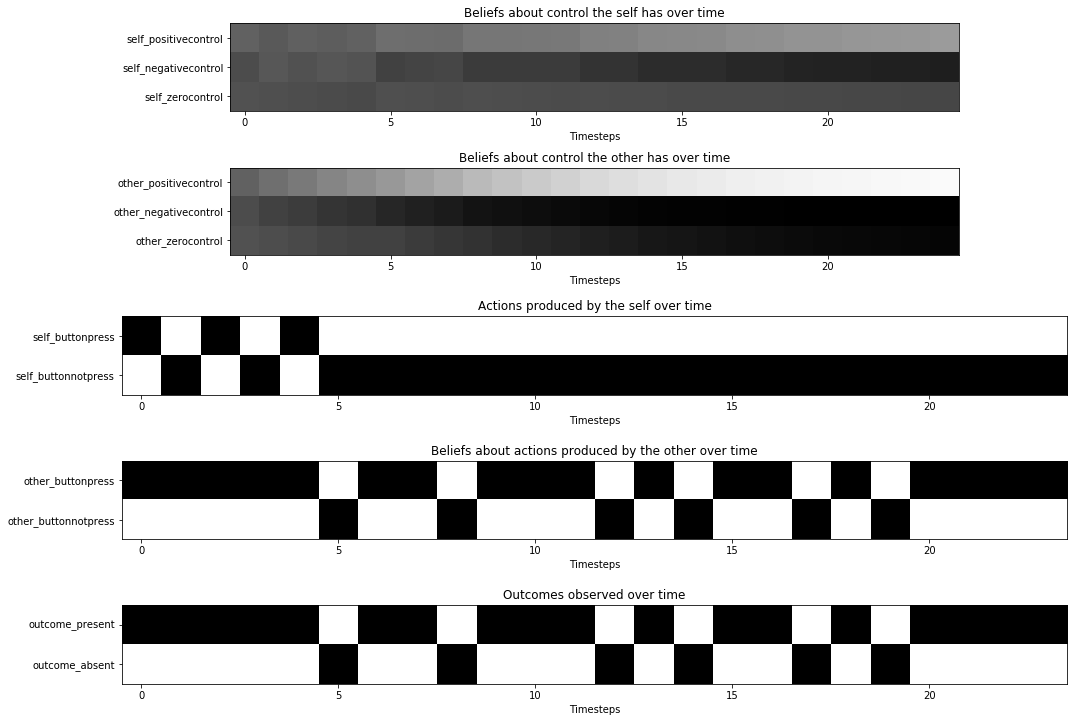

In [60]:
plot_all_choices_beliefs(choice_self_hist, belief_self_context_hist, belief_other_context_hist, expcondition_hist, belief_other_action_hist, outcome_hist)